In [2]:
import cv2
import imutils
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline

def display(image, flip=True, cmap=None, figsize=(6, 6), **kwargs):
    if flip:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image.shape = (hieght, width, channels)
    width=image.shape[1] 
    height=image.shape[0]
    margin=50 
    # dots per inch
    dpi=100.
    # inches
    figsize=((width+2*margin)/dpi, (height+2*margin)/dpi)
    #axes ratio
    left = margin/dpi/figsize[0] 
    bottom = margin/dpi/figsize[1]
    fig = plt.figure(figsize=figsize, dpi=dpi)
    fig.subplots_adjust(left=left, bottom=bottom, right=1.-left, top=1.-bottom)
    # plt.figure(figsize=(6, 6))
    _ = plt.imshow(image, cmap=cmap)
    plt.title(kwargs.get("title", None))
    plt.axis("off")

### Distance Finder class

In [3]:
class DistanceFinder:
    def __init__(self, knownWidth, knownDistance):
        # store the known width of the object (in inches, meters, etc.) and known distance
        # to the object (again, in inches, meters, etc.)
        self.knownWidth = knownWidth
        self.knownDistance = knownDistance

        # initialize the focal length
        self.focalLength = 0

    def calibrate(self, width):
        # compute and store the focal length for calibration
        self.focalLength = (width * self.knownDistance) / self.knownWidth

    def distance(self, perceivedWidth):
        # compute and return the distance from the marker to the camera
        return (self.knownWidth * self.focalLength) / perceivedWidth
    
    @staticmethod
    def findSquareMarker(image):
        # convert the image to grayscale, blur it, and find edges in the image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        edged = cv2.Canny(gray, 35, 125)

        # find contours in the edged image, sort them according to their area (from largest to
        # smallest), and initialize the marker dimensions
        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
        markerDim = None

        # loop over the contours
        for c in cnts:
            # approximate the contour
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)

            # ensure that the contour is a rectangle
            if len(approx) == 4:
                # compute the bounding box and aspect ratio of the approximated contour
                (x, y, w, h) = cv2.boundingRect(approx)
                aspectRatio = w / float(h)

                # check to see if the aspect ratio is within tolerable bounds; if so, store
                # the marker dimensions and break from the loop
                if aspectRatio > 0.9 and aspectRatio < 1.1:
                    markerDim = (x, y, w, h)
                    break

        # return the marker dimensions
        return markerDim

    @staticmethod
    def draw(image, boundingBox, dist, color=(0, 255, 0), thickness=2):
        # draw a bounding box around the marker and display the distance to the marker on the
        # image
        (x, y, w, h) = boundingBox
        cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)
        cv2.putText(
            image, 
            "%.2fft" % (dist / 12), 
            (image.shape[1] - 200, image.shape[0] - 20),
            cv2.FONT_HERSHEY_SIMPLEX, 
            2.0, 
            color, 
            3
        )

        # return the image
        return image

(700, 525, 3)


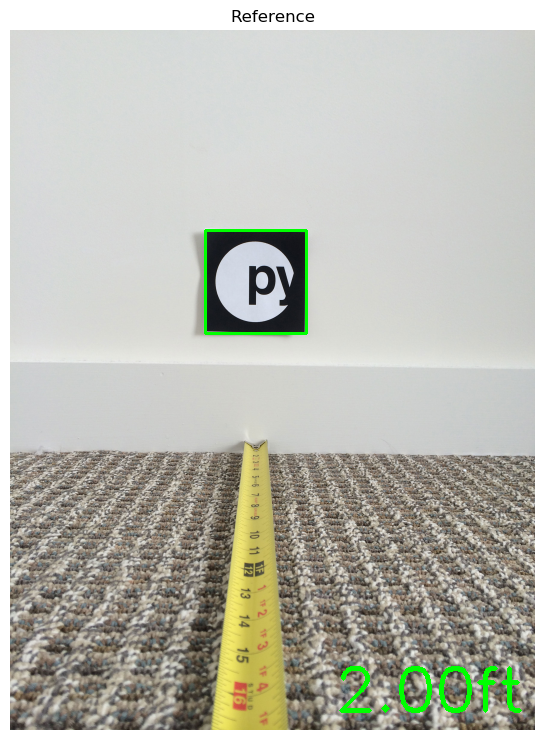

In [4]:
##  ARGS 
reference = "images/ref_24in.jpg"
ref_width_inches = 4.0
ref_distance_inches = 24.0
images="images/distance_finder/"
##


# load the reference image and resize it
refImage = cv2.imread(reference)
refImage = imutils.resize(refImage, height=700)
# print(refImage.shape) 
# initialize the distance finder, find the marker in the image, and calibrate the distance
# finder
df = DistanceFinder(ref_width_inches, ref_distance_inches)
refMarker = DistanceFinder.findSquareMarker(refImage)
df.calibrate(refMarker[2])
 
# visualize the results on the reference image and display it
refImage = df.draw(refImage, refMarker, df.distance(refMarker[2]))
display(refImage, title="Reference")

[INFO] processing image_72in.jpg
[INFO] processing image_48in.jpg
[INFO] processing image_36in.jpg
[INFO] processing image_60in.jpg
[INFO] processing image_84in.jpg


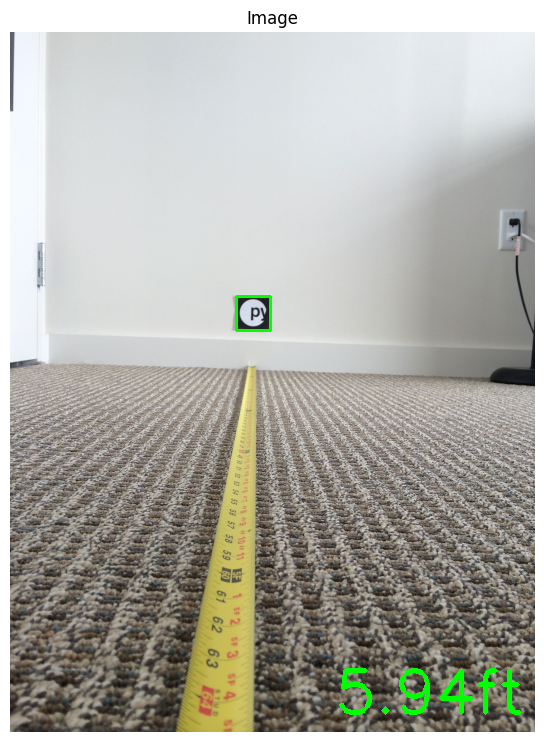

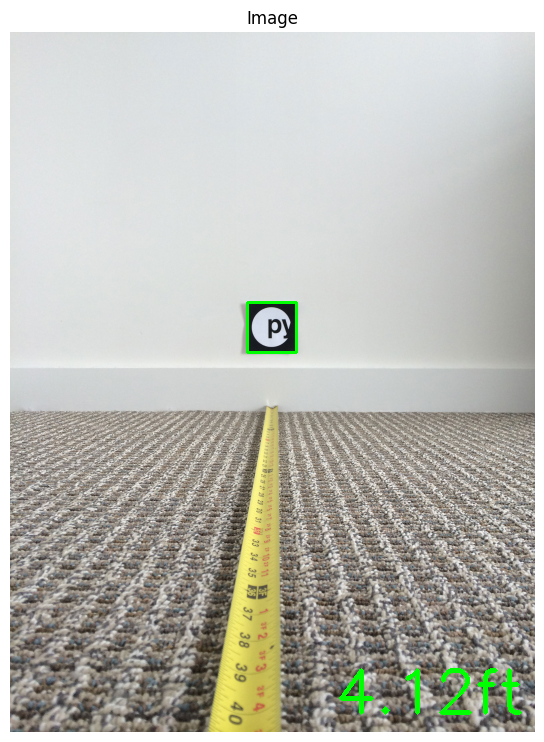

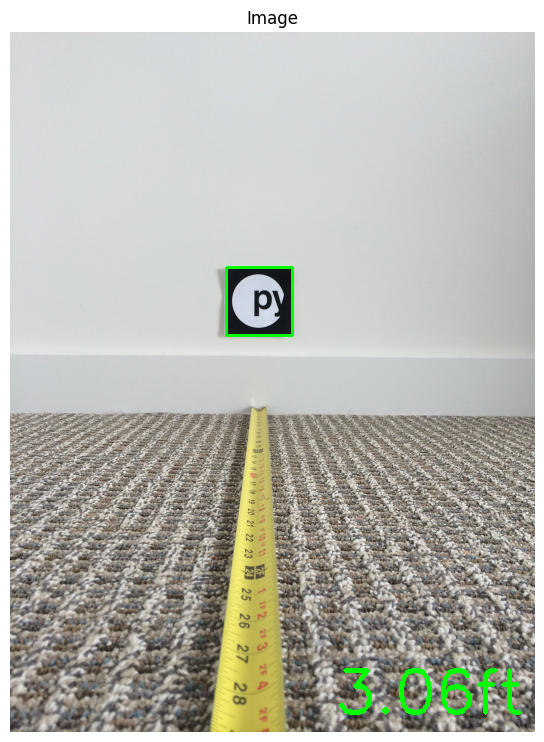

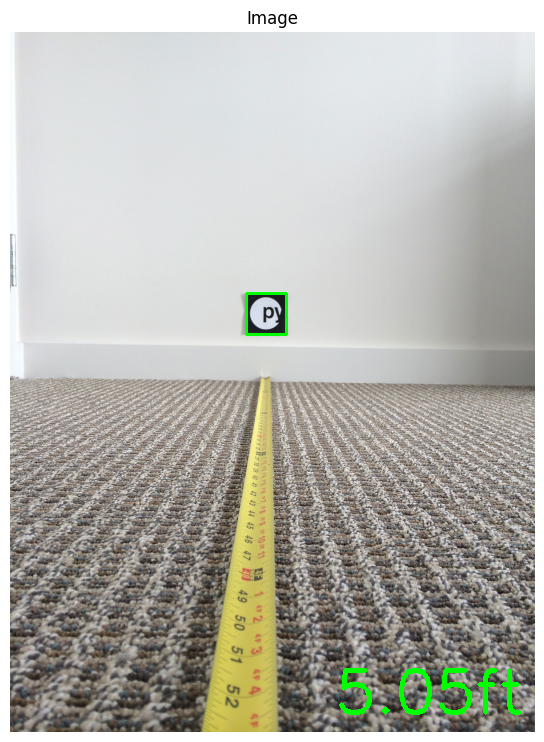

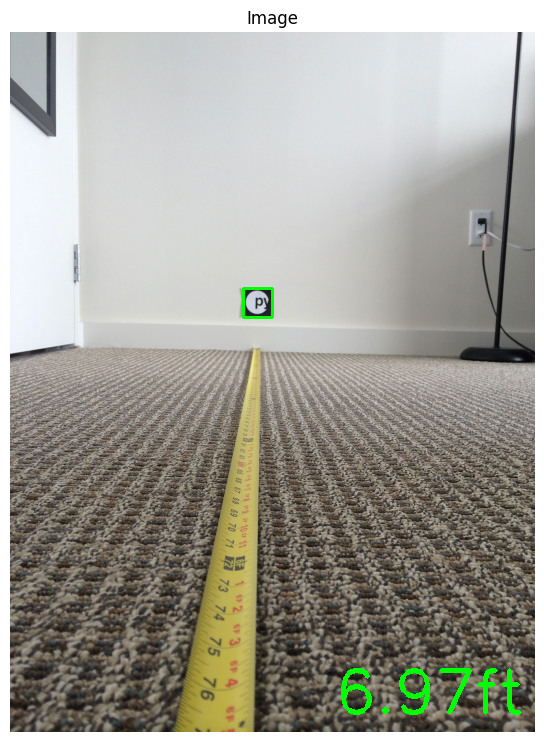

In [8]:
## looping through sample images

for imagePath in paths.list_images(images):
    # extract the filename, load the image, and resize it
    filename = imagePath[imagePath.rfind("/") + 1:]
    image = cv2.imread(imagePath)
    image = imutils.resize(image, height=700)
    print("[INFO] processing {}".format(filename))

    # find the marker in the image
    marker = DistanceFinder.findSquareMarker(image)

    # if the marker is None, then the square marker could not be found in the image
    if marker is None:
        print("[INFO] could not find marker for {}".format(filename))
        continue

    # determine the distance to the marker
    distance = df.distance(marker[2])

    # visualize the results on the image and display it
    image = df.draw(image, marker, distance)
    display(image, title="Image")